In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [4]:
#separate the data and labels so that it will be easy for understanding
data = df.iloc[:,:-1].values
labels = df.iloc[:,-1].values
labels

array([1., 1., 1., ..., 0., 0., 0.])

In [8]:
# Split the data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.2, random_state = 42)

# Convert the data to PyTorch tensors
train_data = torch.from_numpy(train_data).type(torch.Tensor)
test_data = torch.from_numpy(test_data).type(torch.Tensor)
train_labels = torch.from_numpy(train_labels).type(torch.Tensor)
test_labels = torch.from_numpy(test_labels).type(torch.Tensor)

In [9]:
min = torch.min(torch.tensor(train_data, dtype=torch.float32))
max = torch.max(torch.tensor(train_data, dtype=torch.float32))

# Normalize the data
train_data = (train_data - min) / (max - min)
test_data = (test_data - min) / (max - min)

In [15]:
# Conver the labels to boolean
train_labels = train_labels.bool()
test_labels = test_labels.bool()

In [19]:
# Seperate the data into normal and abnormal
normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

abnormal_train_data = train_data[~train_labels]
abnormal_test_data = test_data[~test_labels]

print(normal_train_data.size())

torch.Size([2328, 140])


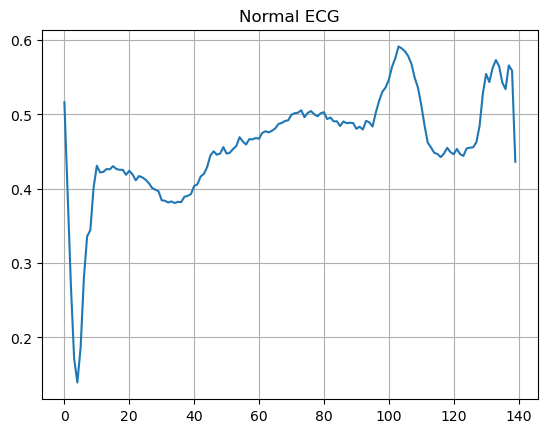

In [20]:
# Plot the normal data
plt.plot(np.arange(140), normal_train_data[0].numpy())
plt.grid()
plt.title('Normal ECG')
plt.show()

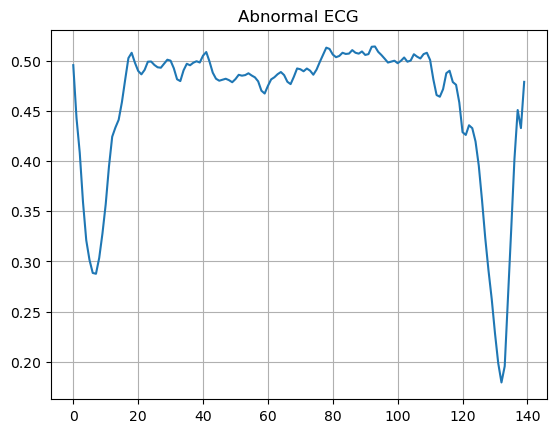

In [21]:
# Plot the abnormal data
plt.plot(np.arange(140), abnormal_train_data[0].numpy())
plt.grid()
plt.title('Abnormal ECG')
plt.show()

In [22]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(140, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 140),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [45]:
train_loader = torch.utils.data.DataLoader(dataset=normal_train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=normal_test_data, batch_size=64, shuffle=True)

In [46]:
# Create a instance of the model
ae = Autoencoder()

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

# Train the model
num_epochs = 20
print('Training the model...')
for epoch in range(num_epochs):
    for data in train_loader:
        outputs = ae(data)

        loss = criterion(outputs, data)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

# Validate the model
print('Validating the model...')
ae.eval()
with torch.no_grad():
    for data in val_loader:
        outputs = ae(data)
        loss = criterion(outputs, data)

    print(f'Validation Loss: {loss.item():.4f}')

Training the model...
Epoch [0/20], Loss: 0.0038
Epoch [1/20], Loss: 0.0019
Epoch [2/20], Loss: 0.0012
Epoch [3/20], Loss: 0.0010
Epoch [4/20], Loss: 0.0009
Epoch [5/20], Loss: 0.0010
Epoch [6/20], Loss: 0.0010
Epoch [7/20], Loss: 0.0014
Epoch [8/20], Loss: 0.0009
Epoch [9/20], Loss: 0.0010
Epoch [10/20], Loss: 0.0012
Epoch [11/20], Loss: 0.0012
Epoch [12/20], Loss: 0.0009
Epoch [13/20], Loss: 0.0016
Epoch [14/20], Loss: 0.0011
Epoch [15/20], Loss: 0.0008
Epoch [16/20], Loss: 0.0007
Epoch [17/20], Loss: 0.0006
Epoch [18/20], Loss: 0.0009
Epoch [19/20], Loss: 0.0006
Validating the model...
Validation Loss: 0.0005


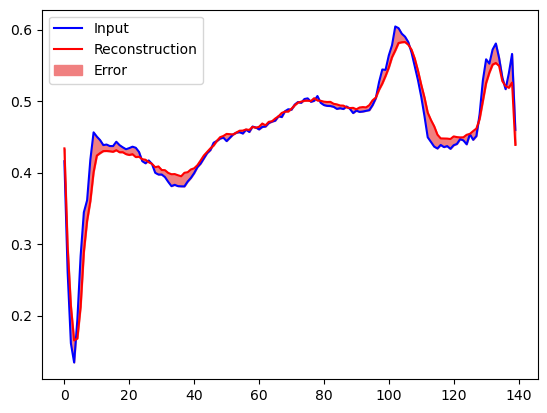

In [47]:
enc_img = ae.encoder(normal_test_data[2])
dec_img = ae.decoder(enc_img)
plt.plot(normal_test_data[2], 'b')
plt.plot(dec_img.detach().numpy(), 'r')
plt.fill_between(np.arange(140), dec_img.detach().numpy(), normal_test_data[2], color='lightcoral')
plt.legend(labels=['Input', 'Reconstruction', 'Error'])
plt.show()

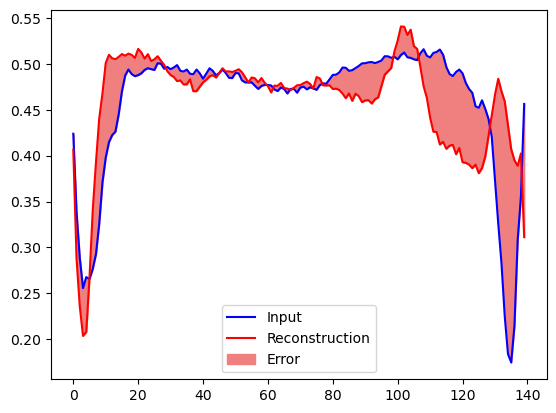

In [48]:
enc_img = ae.encoder(abnormal_test_data[2])
dec_img = ae.decoder(enc_img)
plt.plot(abnormal_test_data[2], 'b')
plt.plot(dec_img.detach().numpy(), 'r')
plt.fill_between(np.arange(140), dec_img.detach().numpy(), abnormal_test_data[2], color='lightcoral')
plt.legend(labels=['Input', 'Reconstruction', 'Error'])
plt.show()